# Web Scraping and Big Data


### Part 1: Scraping Craigslist

In this section, I will use BeautifulSoup to scrape data for hundreds of apartments from Philadelphia's Craigslist portal.

### Part 2: Exploring a "large" dataset of your choice

In this section, I will use datashader to create an animated timelapse of the vehicle collisions in NYC (2012-2019) dataset.

## Part 1: Scraping Craigslist

In this part, we'll be first extracting information of apartments from Craigslist search results. BeautifulSoup will be used to extract the relevant information from the HTML text. 

### Getting the HTML

In [1]:
import requests

In [2]:
url_base = 'http://philadelphia.craigslist.org/search/apa'
params = {'bedrooms': 1}
rsp = requests.get(url_base, params=params)

In [3]:
# Note that requests automatically created the right URL
print(rsp.url)

https://philadelphia.craigslist.org/search/apa?bedrooms=1


## 1.1 Parse the HTML

We have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [4]:
from bs4 import BeautifulSoup

In [5]:
soup = BeautifulSoup(rsp.content, 'html.parser')

In [6]:
rows = soup.select('.result-row')

In [7]:
len(rows)

120

## 1.2 Find the relevant pieces of information

We will try to explore the first element in the list of 120 apartments. 

From this HTML, the information I think useful include:

- The apartment price
- The number of bedrooms and square footage
- The apartment title
- The datetime string of the posting, e.g., '2019-03-23 12:07'

For the first apartment, we'll print out each of these pieces of information, using BeautifulSoup to select the proper elements.

In [8]:
price = soup.select_one('.result-price').text
print(price)

$2500


In [9]:
br_ft2 = soup.select_one('.housing').text
print(br_ft2)


                    3br -
                


In [10]:
title = soup.select_one('.result-title').text
print(title)

Three Separate Suites, Shared Roofdeck


In [11]:
time = soup.select_one('.result-date')['datetime']
print(time)

2019-04-03 14:32


## 1.3 Functions to format the results 

In this section, I'll define two functions that take the price and time results from the last section and format them properly.

In [12]:
import re

In [13]:
def format_size_and_bedrooms(size_string):
    """
    Extract size and number of bedrooms from the raw
    text, using regular expressions
    """
    split = re.findall("\n(.*?) -", size_string)
    
    # both size and bedrooms are listed
    if len(split) == 2:
        n_brs = split[0].strip().replace('br', '')
        this_size = split[1].strip().replace('ft2', '')
    # only bedrooms is listed
    elif 'br' in split[0]:
        n_brs = split[0].strip().replace('br', '')
        this_size = np.nan
    # only size is listed
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].strip().replace('ft2', '')
        n_brs = np.nan
    
    # return floats
    return float(this_size), float(n_brs)

In [14]:
def format_price(price_string):
    # Format the price string and return a float
    # 
    # This will involve using the string.strip() function to 
    # remove unwanted characters
    clean_price = price_string.strip('$')
    clean_price = float(clean_price)
    
    return clean_price

In [15]:
import datetime

In [16]:
def format_time(date_string):
    # Return a Datetime object from the datetime string
    
    return  datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M')

## 1.4: Putting it all together

The following code will loop over 4 pages of search results and scrape data for about 500 apartments.

In the code below, the outer for loop will loop over 4 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

After filling in the missing pieces and executing the code cell, we'll have a Data Frame called `results` that holds the data for 480 apartment listings.

#### Notes

Craigslist will temporarily ban our IP address (for a very short time) if we scrape too much at once. Therefore, I've added a `sleep()` function to the for loop to wait 30 seconds between scraping requests.

In [17]:
from time import sleep

In [18]:
import numpy as np
import pandas as pd

In [19]:
results = []

# search in batches of 120 for 4 pages
# NOTE: you will get temporarily banned if running more than ~4 pages or so
# the API limits are more leninient during off-peak times, and you can try
# experimenting with more pages
max_pages = 4
results_per_page = 120
search_indices = np.arange(0, max_pages*results_per_page + 1, results_per_page) 
url = 'http://philadelphia.craigslist.org/search/apa'

# loop over each page of search results
for i, s in enumerate(search_indices):
    print('Processing page %s...' % (i+1) )
    
    # get the response
    resp = requests.get(url, params={'bedrooms': 1, 's': s})
    
    # get the list of all apartments
    apts = BeautifulSoup(resp.content, 'html.parser').select('.result-row')
    print("number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:
        
        # the bedrooms/size string
        sizes_brs = apt.select('.housing')[0].text

        # the title string
        title = apt.select('.result-title')[0].text
        
        # Ythe price string
        price = apt.select('.result-price')[0].text

        # the time string
        dtime = apt.select('.result-date')[0]['datetime']
        
        # format using functions from Part 1.3
        sizes, brs = format_size_and_bedrooms(sizes_brs)
        price = format_price(price)
        dtime = format_time(dtime)
        
        # save the result
        page_results.append([dtime, price, sizes, brs, title])
        
    
    # create a dataframe and save
    col_names = ['time', 'price', 'size', 'brs', 'title']
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)
    
    print("sleeping for 30 seconds between calls")
    sleep(30)
    
# Finally, concatenate all the results
results = pd.concat(results, axis=0)

Processing page 1...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 2...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 3...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 4...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 5...
number of apartments =  120
sleeping for 30 seconds between calls


In [20]:
results.head()

,time,price,size,brs,title
0,2019-04-03 14:32:00,2500.0,NaN,3.0,"Three Separate Suites, Shared Roofdeck"
1,2019-04-03 14:32:00,1695.0,900.0,2.0,"1609 Bainbridge St 1st fl Avail 05/06/19, $1,6..."
2,2019-04-03 14:31:00,2025.0,NaN,2.0,"""YIKES"" Student Rental West Chester Borough 2 BR"
3,2019-04-03 14:31:00,1615.0,1091.0,2.0,Great Price for This Gorgeous 2 Bedroom Apartm...
4,2019-04-03 14:31:00,1880.0,744.0,1.0,"Enjoy living in this SPACIOUS, and GRACIOUS, N..."


In [21]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 119
Data columns (total 5 columns):
time     600 non-null datetime64[ns]
price    600 non-null float64
size     382 non-null float64
brs      600 non-null float64
title    600 non-null object
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 28.1+ KB


## 1.5: Plotting the distribution of prices

I'll use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

In [22]:
import matplotlib.pyplot as plt

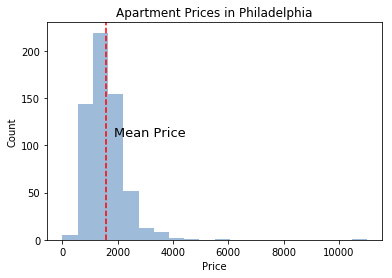

In [23]:
plt.hist(results['price'], bins=20, facecolor='#9ebcda')

plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Apartment Prices in Philadelphia')
plt.axvline(x=results['price'].mean(), linestyle='--', color='r')
plt.text(1850, 110, 'Mean Price', fontsize=13)
plt.show()

C:\Users\MaiRZ\Anaconda3\envs\musa\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\MaiRZ\Anaconda3\envs\musa\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


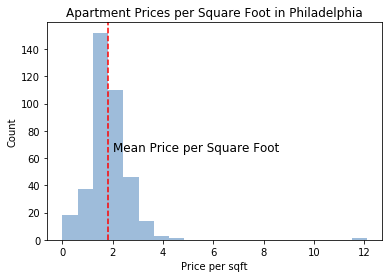

In [24]:
plt.hist(results['price']/results['size'], bins=20, facecolor='#9ebcda')

plt.xlabel('Price per sqft')
plt.ylabel('Count')
plt.title('Apartment Prices per Square Foot in Philadelphia')
plt.axvline(x=np.mean(results['price']/results['size']), linestyle='--', color='r')
plt.text(2, 65, 'Mean Price per Square Foot', fontsize=12)
plt.show()

## 1.6 Comparing prices for different sizes 

In this part, I will use `altair` to explore the relationship between price, size, and number of bedrooms.

With this sort of plot, we can easily see the outlier apartments in terms of size and price.

In [25]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

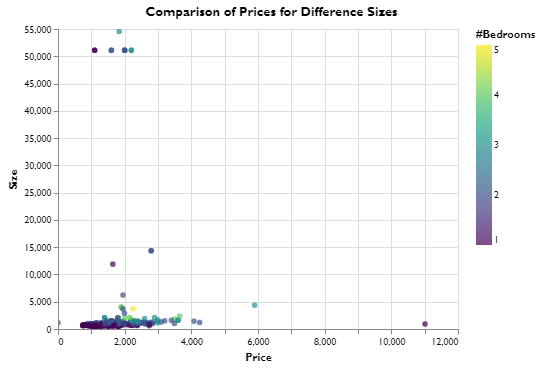

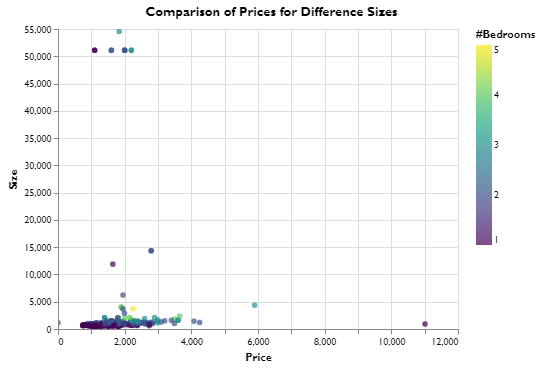

In [26]:
chart = alt.Chart(results).mark_circle().encode(
    alt.X('price', scale=alt.Scale(zero=False), axis=alt.Axis(title='Price')),
    alt.Y('size', scale=alt.Scale(zero=False, padding=1), axis=alt.Axis(title='Size')),
    color=alt.Color('brs', legend=alt.Legend(title="#Bedrooms"), scale=alt.Scale(scheme='viridis')),
    tooltip = [alt.Tooltip('title', title = 'Title'),
               alt.Tooltip('price', title = 'Apartment Price'),
               alt.Tooltip('size', title = 'Apartment Size'),
              alt.Tooltip('brs', title = 'Number of Bedrooms'),
              alt.Tooltip('time:N', title = 'Time'),]
).properties(
    title='Comparison of Prices for Difference Sizes'
)

# Make the plot interactive
chart.interactive()

## Part 2: Making an animated map with Datashader

In this part, I will load the NYC vehicle collitions dataset and make an animated map of the data using datashader. 

In [27]:
import geopandas as gpd
import zipfile

In [28]:
with zipfile.ZipFile("NYPD_Motor_Vehicle_Collisions.zip") as z:
   with z.open("NYPD_Motor_Vehicle_Collisions.csv") as f:
      df = pd.read_csv(f, header=0)

C:\Users\MaiRZ\Anaconda3\envs\musa\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df['complete_time'] = df['DATE'] + ' ' + df['TIME']
df = df[['complete_time', 'LATITUDE', 'LONGITUDE', 'NUMBER OF PERSONS INJURED']]

df['complete_time'] = pd.to_datetime(df['complete_time'], format='%m/%d/%Y %H:%M')
df['hour'] = df['complete_time'].dt.hour

In [30]:
df.head(10)

,complete_time,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,hour
0,2019-03-19 00:00:00,40.653927,-73.953760,0.0,0
1,2019-03-19 00:00:00,40.586670,-73.966156,0.0,0
2,2019-03-19 00:00:00,40.667090,-73.763760,0.0,0
3,2019-03-19 00:00:00,NaN,NaN,0.0,0
4,2019-03-19 00:00:00,40.692463,-73.810820,0.0,0
5,2019-03-19 00:00:00,40.681866,-73.745450,3.0,0
6,2019-03-19 00:05:00,40.787170,-73.949990,2.0,0
7,2019-03-19 00:20:00,40.878643,-73.871605,0.0,0
8,2019-03-19 00:20:00,NaN,NaN,4.0,0
9,2019-03-19 00:24:00,40.801125,-73.929880,0.0,0


In [31]:
df.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)

In [32]:
len(df)

1279177

In [33]:
from shapely.geometry import Point

df['Coordinates'] = list(zip(df.LONGITUDE, df.LATITUDE))
df['Coordinates'] = df['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')

In [34]:
gdf = gpd.GeoDataFrame(gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})

In [35]:
gdf = gdf.to_crs(epsg=3857)

In [36]:
gdf['x'] = gdf['Coordinates'].x
gdf['y'] = gdf['Coordinates'].y

In [37]:
gdf.head()

,complete_time,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,hour,Coordinates,x,y
0,2019-03-19,40.653927,-73.953760,0.0,0,POINT (-8232494.905447964 4961429.209742942),-8.232495e+06,4.961429e+06
1,2019-03-19,40.586670,-73.966156,0.0,0,POINT (-8233874.821855837 4951565.422474091),-8.233875e+06,4.951565e+06
2,2019-03-19,40.667090,-73.763760,0.0,0,POINT (-8211344.20219724 4963360.833927889),-8.211344e+06,4.963361e+06
4,2019-03-19,40.692463,-73.810820,0.0,0,POINT (-8216582.897433973 4967085.308970755),-8.216583e+06,4.967085e+06
5,2019-03-19,40.681866,-73.745450,3.0,0,POINT (-8209305.942320817 4965529.614473124),-8.209306e+06,4.965530e+06


In [38]:
import datashader.transfer_functions as tf
from datashader.utils import export_image
import datashader as ds
from colorcet import fire

In [39]:
NYC = x_range, y_range = ((-8242000,-8210000), (4965000,4990000))
plot_width  = int(750)
plot_height = int(plot_width//1.2)

def create_image(df, x_range, y_range, w=plot_width, h=plot_height, cmap=fire):
    
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot crash locations, counting number of persons injured
    agg = cvs.points(df, 'x', 'y',  ds.count('NUMBER OF PERSONS INJURED'))
    
    # shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [40]:
def convert_to_12hour(hr24):
    """
    Convert from 24 hr to 12 hr.
    """
    from datetime import datetime
    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

In [41]:
def plot_crashes_by_hour(fig, df, hour):
    """
    Plot the crashes for particular hour
    """
    # generate the datashader image
    df = df.loc[df['hour']==hour]
    img = create_image(df, *NYC)
    
    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img)
    ax.axis('off')
    
    # add a text label for the hour
    ax.text(0.04, 0.92, convert_to_12hour(hour), color='white', 
            fontsize=25, ha='left', transform=ax.transAxes)
    
    ax.text(0.04, 0.80, 'Crashes by hour\nin New York City\n(2012-2019)', color='white', 
            fontsize=20, ha='left', transform=ax.transAxes)
    
    plt.axis('equal')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    #fig.tight_layout()    
   
    # draw the figure and return the image
    fig.canvas.draw()   
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

In [42]:
import imageio

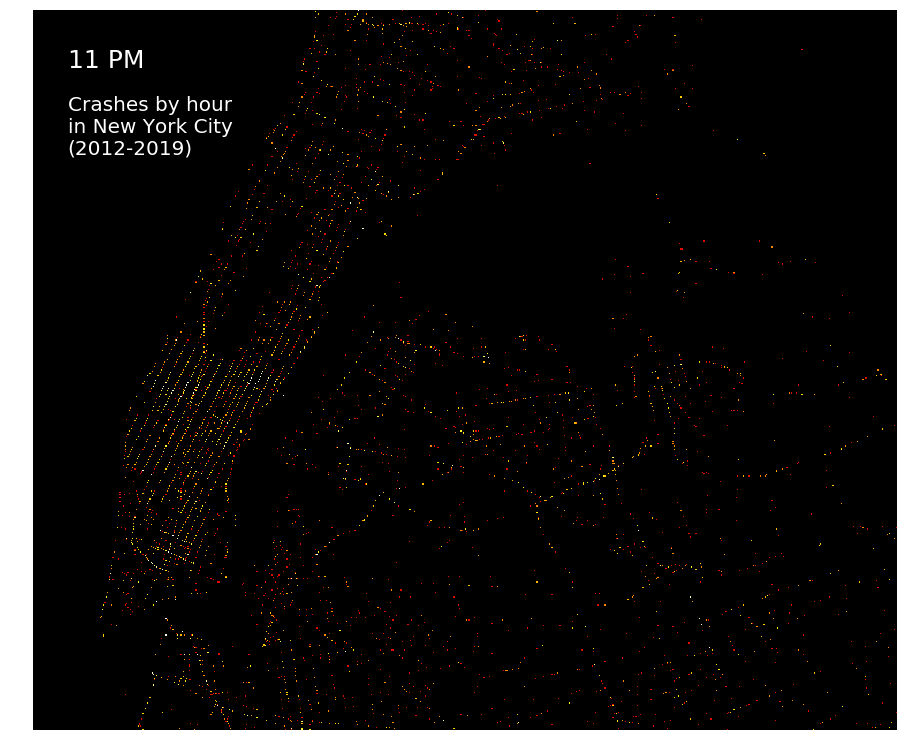

In [43]:
# create a figure
fig, ax = plt.subplots(figsize=(12, 10))

# save the GIF
hours = range(24)
imageio.mimsave('test.gif', [plot_crashes_by_hour(fig, gdf, hr) for hr in hours], fps=1);